In [222]:
import numpy as np
from einops import repeat
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
import torch.optim as optim

In [33]:
# Generate data
def generate_data(N=10000):
    x = np.random.uniform(-1.0, 1.0, N)
    epsilon = (0.5 + 2 * np.abs(x)) * np.random.randn(N)
    y_true = 0.8 * x ** 2 - 0.5 * x + np.sin(5 * x) + 0.5 * np.log(np.abs(x)) # ground truth 함수 값
    y_real = y_true + epsilon # dataset
    return x, y_true, y_real

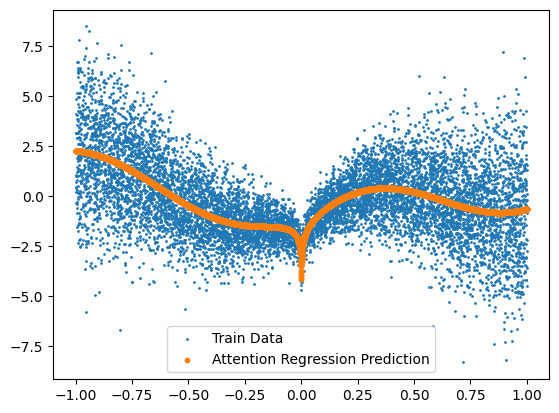

In [191]:
x, y_true, y_real = generate_data()

# Plotting function
def plot_figure(x, y, X, Y, label):
    fig, ax = plt.subplots()
    plt.scatter(X, Y, s=1, label='Train Data')
    plt.scatter(x, y, s=10, label=label)
    ax.legend()
    plt.show()

# Visualize the result
plot_figure(x, y_true, x, y_real, label='Attention Regression Prediction')

# Attention

In [205]:
class Attention():
    def __init__(self, key, value, d=0.1):
        self.key = key  # input (m, 1) array
        self.value = value # output (m, 1) array
        self.d = d # scalar

    # Compute the attention scores without using loops
    def compute_attention_score(self, query, key, d): # query (b, 1) / key (m, 1)
        # Repeat query and key to match the shapes for broadcasting
        repeated_query = repeat(query, 'b 1 -> b (repeat 1) 1', repeat=len(key)) # repeated_query = (b, m, 1)
        repeated_key = repeat(key, 'm 1 -> (repeat 1) m 1', repeat=len(query)) # repeated_key = (b, m, 1)
        print(f'query, key >> {query.shape}/{key.shape}')
        print(f'repeated query, key >> {repeated_query.shape}/{repeated_key.shape}')
 
        self.attention_score = np.squeeze((-0.5 * (repeated_query - repeated_key) ** 2)/d, axis=2) # (b, m, 1) >> (b, m)
        # self.attention_score = repeated_query @ repeated_key.transpose(1, 0) / d
        print(f'transpose >> {repeated_key.transpose(1, 0, 2).shape}')
        print(f'attention_score >> {self.attention_score.shape}')

        return self.attention_score  # Output shape is (B, m)

    def compute_attention_weight(self, query, key, d):
        self.attention_weight = np.zeros((len(query), len(key)))
        attention_score = self.compute_attention_score(query, key, d) #  (b, 1) @ (m, 1)^T = (b, m)
        exp_scores = np.exp(attention_score)
        print(f'exp_scores >> {exp_scores.shape}')
        self.attention_weight = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        print(f'attention_weight >> {self.attention_weight.shape}')
        return self.attention_weight  # Output is (b, m)

    def compute_attention(self, query, key, value, d):
        attention_weight = self.compute_attention_weight(query, key, d)
        attention = np.dot(attention_weight, value)  # (b, m) @ (m, 1) = (b, 1)
        return attention  # Output is (b, 1)

    def __call__(self, query):
        return self.compute_attention(query, self.key, self.value, self.d)

query, key, value >> (100,)/(10000, 1)/(10000, 1)
query, key >> (100, 1)/(10000, 1)
repeated query, key >> (100, 10000, 1)/(100, 10000, 1)
transpose >> (10000, 100, 1)
attention_score >> (100, 10000)
exp_scores >> (100, 10000)
attention_weight >> (100, 10000)


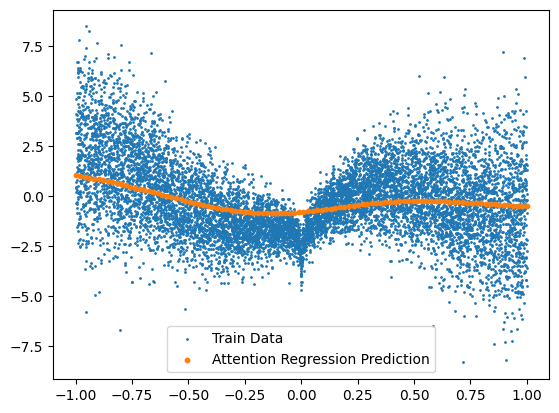

In [206]:
# Prepare query and value for Attention
x_query = np.linspace(-1, 1, 100)
x_key = x.reshape(-1, 1)
y_value = y_real.reshape(-1, 1)
print(f'query, key, value >> {x_query.shape}/{x_key.shape}/{y_value.shape}')

# Apply Attention mechanism
attention_model = Attention(x_key, y_value)
y_pred= attention_model(x_query.reshape(-1, 1))

# Flatten the predictions for plotting
y_pred = y_pred.flatten()

# Visualize the result
plot_figure(x_query, y_pred, x, y_real, label='Attention Regression Prediction')

In [201]:
class Attention():
    def __init__(self, key, value, d=0.01):
        self.key = key # (m, 1)
        self.value = value # (m, 1)
        self.d = d

    def compute_attention(self, query, keys, values, d):
        attention_weight = self.compute_attention_weights(query, keys, d) # (b, m)
        values = np.repeat(values.reshape(1, -1, 1), attention_weight.shape[0], axis=0) # (b, m, 1)
        unnormalized_attention = np.multiply(attention_weight, values) # (b, m, 1)
        attention = np.sum(unnormalized_attention, axis=1) # (b, 1)
        print(f'attention >> {attention.shape}')
        return attention # (b, 1)

    def compute_attention_weights(self, query, keys, d):
        repeated_query = repeat(query, 'b 1 -> b (repeat 1) 1', repeat=len(keys)) # repeated_query = (b, m, 1)
        repeated_key = repeat(keys, 'm 1 -> (repeat 1) m 1', repeat=len(query)) # repeated_key = (b, m, 1)
        attention_logits = -0.5 * (repeated_query - repeated_key)**2 / d
        # attention_logits = repeated_query * repeated_key / d
        exp_scores = np.exp(attention_logits)
        attention_weight = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        print(f'attention_weight >> {attention_weight.shape}')
        return attention_weight # (b, m)

    def __call__(self, query):
        return self.compute_attention(query, self.key, self.value, self.d)


query, key, value >> (100,)/(10000, 1)/(10000, 1)
attention_weight >> (100, 10000, 1)
attention >> (100, 1)


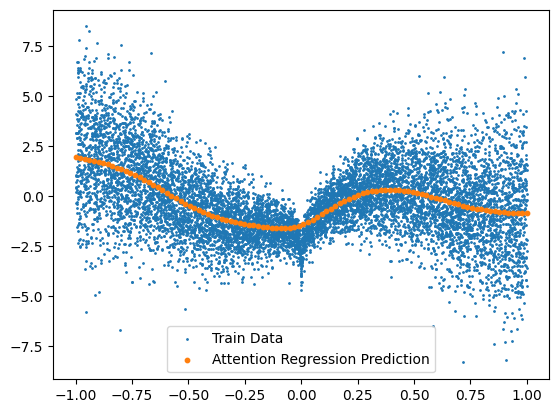

In [202]:
# Prepare query and value for Attention
x_query = np.linspace(-1, 1, 100)
x_key = x.reshape(-1, 1)
y_value = y_real.reshape(-1, 1)
print(f'query, key, value >> {x_query.shape}/{x_key.shape}/{y_value.shape}')

# Apply Attention mechanism
attention_model = Attention(x_key, y_value)
y_pred= attention_model(x_query.reshape(-1, 1))

# Flatten the predictions for plotting
y_pred = y_pred.flatten()

# Visualize the result
plot_figure(x_query, y_pred, x, y_real, label='Attention Regression Prediction')

In [194]:
class Attention():
    def __init__(self, key, value, len=0.01):
        self.key = key.reshape(-1, 1) # (m, d) array
        self.value = value.reshape(-1, 1) # (m, d) array
        self.len = len

    def compute_attention_score(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention score: (b, m) array
        """
        query = einops.repeat(query, 'b d -> b m d', m=1)
        key = einops.repeat(key, 'm d -> b m d', b=1)
        distance = einops.reduce((query - key)**2 / self.len, 'b m d -> b m', 'sum')
        attention_score = - 0.5 * distance
        return attention_score

    def compute_softmax(self, vector):
        """
        Input:
        - vector: (b, m) array
        Output:
        - softmax vector: (b, m) array
        """
        exp_v = torch.exp(vector)
        attention_weight = exp_v / torch.sum(exp_v, axis=1, keepdims=True)
        return attention_weight

    def compute_attention_weight(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention weight: (b, m) array
        """
        score_vector = self.compute_attention_score(query, key)
        attention_weight = self.compute_softmax(score_vector)

        return attention_weight

    def compute_attention(self, query, key, value):
        """
        Input:
        - query: (b, d) array
        - key: (m, d) array
        - value: (m, d) array
        Output:
        - attention output: (b, d) array
        """
        attention_weight = self.compute_attention_weight(query, key)
        attention_output = attention_weight @ value
        return attention_output

    def __call__(self, query):
        return self.compute_attention(query, self.key, self.value)

In [217]:
class Attention():
    def __init__(self, key, value, len=0.1):
        self.key = key.reshape(-1, 1) # (m, d) array
        self.value = value.reshape(-1, 1) # (m, d) array
        self.len = len

    def compute_attention_score(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention score: (b, m) array
        """
        query = einops.repeat(query, 'b d -> b m d', m=1)
        key = einops.repeat(key, 'm d -> b m d', b=1)
        print(f'query, key >> {query.shape}/{key.shape}')
        distance = einops.reduce((query - key)**2 / self.len, 'b m d -> b m', 'sum')
        attention_score = - 0.5 * distance
        # attention_score = query @ key.transpose(1, 0) / self.len
        return attention_score

    def compute_softmax(self, vector):
        """
        Input:
        - vector: (b, m) array
        Output:
        - softmax vector: (b, m) array
        """
        exp_v = np.exp(vector)
        attention_weight = exp_v / np.sum(exp_v, axis=1, keepdims=True)
        return attention_weight

    def compute_attention_weight(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention weight: (b, m) array
        """
        score_vector = self.compute_attention_score(query, key)
        attention_weight = self.compute_softmax(score_vector)

        return attention_weight

    def compute_attention(self, query, key, value):
        """
        Input:
        - query: (b, d) array
        - key: (m, d) array
        - value: (m, d) array
        Output:
        - attention output: (b, d) array
        """
        attention_weight = self.compute_attention_weight(query, key)
        attention_output = attention_weight @ value
        return attention_output

    def __call__(self, query):
        return self.compute_attention(query, self.key, self.value)

query, key, value >> (100,)/(10000, 1)/(10000, 1)
query, key >> (100, 1, 1)/(1, 10000, 1)


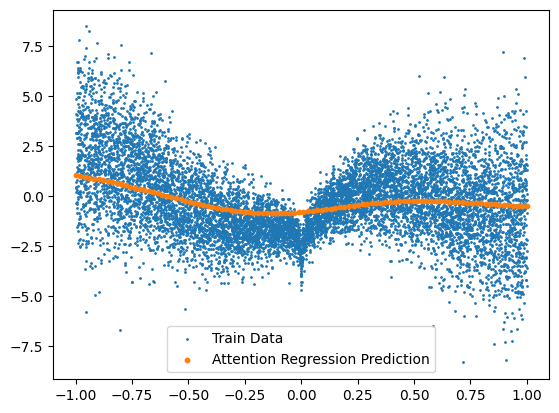

In [218]:
# Prepare query and value for Attention
x_query = np.linspace(-1, 1, 100)
x_key = x.reshape(-1, 1)
y_value = y_real.reshape(-1, 1)
print(f'query, key, value >> {x_query.shape}/{x_key.shape}/{y_value.shape}')

# Apply Attention mechanism
attention_model = Attention(x_key, y_value)
y_pred= attention_model(x_query.reshape(-1, 1))

# Flatten the predictions for plotting
y_pred = y_pred.flatten()

# Visualize the result
plot_figure(x_query, y_pred, x, y_real, label='Attention Regression Prediction')

# Attention training code

In [235]:
class AttentionModule(nn.Module): 
    def __init__(self, d_output=1, d=100): 
        super().__init__() 
        self.d = d 
        self.d_output = d_output 
        self.K = nn.LazyLinear(self.d) 
        self.Q = nn.LazyLinear(self.d) 
        self.V = nn.LazyLinear(self.d_output)

    def compute_attention_score(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention score: (b, m) array
        """
        query = einops.repeat(query, 'b d -> b m d', m=1)
        key = einops.repeat(key, 'm d -> b m d', b=1)
        distance = einops.reduce((query - key)**2 / self.len, 'b m d -> b m', 'sum')
        attention_score = - 0.5 * distance
        return attention_score

    def compute_softmax(self, vector):
        """
        Input:
        - vector: (b, m) array
        Output:
        - softmax vector: (b, m) array
        """
        exp_v = np.exp(vector)
        attention_weight = exp_v / np.sum(exp_v, axis=1, keepdims=True)
        return attention_weight

    def compute_attention_weight(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention weight: (b, m) array
        """
        score_vector = self.compute_attention_score(query, key)
        attention_weight = self.compute_softmax(score_vector)

        return attention_weight

    def compute_attention(self, query, key, value):
        """
        Input:
        - query: (b, d) array
        - key: (m, d) array
        - value: (m, d) array
        Output:
        - attention output: (b, d) array
        """
        attention_weight = self.compute_attention_weight(query, key)
        attention_output = attention_weight @ value
        return attention_output

    def forward(self, query, key, value): 
        query = self.Q(query) 
        key = self.K(key) 
        value = self.V(value) 
        return self.compute_attention(query, key, value)

In [236]:
X_tensor = torch.tensor(x_query, dtype=torch.float32).reshape(-1, 1)
Y_tensor = torch.tensor(y_real, dtype=torch.float32).reshape(-1, 1) # y_real

/var/folders/sz/y81_2ywx1tdcbk0zcpn5rl9c0000gn/T/ipykernel_5715/2920262818.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(y_real, dtype=torch.float32).reshape(-1, 1) # y_real


In [ ]:
#중첩함수 -> 코드 수정을 덜 할 수 있음
def make_train_step(model, optimizer, loss_fun):
    def train_step(query, key, value):
        model.train()
        predict = model(query, key, value) # forward pass
        loss = loss_fun(predict, value) # loss computation
        loss.backward() # backward pass
        optimizer.step() # gradient descent
        optimizer.zero_grad() # reset gradient
        return loss.item()
    return train_step

def train(batch_size=256, epoch=300):
    indices = np.arange(len(X.shape[0]))
    np.random.shuffle(indices)
    for _ in range(epoch):
        '''
        # YOUR CODE: minibatch sampling 을 위한 idx_list 리스트를 구현하세요
        # - 조건 1. batch 크기는 256,
        # - 조건 2. 매 epoch 마다 idx_list 가 랜덤하게 바뀌어야 합니다
        '''
        idx_list = indices[batch_size*epoch:batch_size*epoch+batch_size]
        
        for index in idx_list:
            query = X_tensor[index]
            key = X_tensor[index]
            value = Y_tensor[index]
            loss = train_step(query, key, value)
        if _ % 100 == 0:
            print(f'epoch: {_}, Train loss: {loss}')

In [237]:
model = AttentionModule(d_output=1, d=5).to('cpu')

/Users/minkyuramen/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [239]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fun = nn.MSELoss()
train_step = make_train_step(model, optimizer, loss_fun)